Refs: 

https://github.com/Coffee4MePlz/Notebooks_NN_Physics/blob/Ver%C3%A3o-PT-br/05-Exemplo%202%20OHS.ipynb

https://github.com/Coffee4MePlz/Notebooks_NN_Physics/blob/Ver%C3%A3o-PT-br/04-Exemplo%201%20Pendulo.ipynb


# PINNs - Oscilador Harmônico

A EDO de referência é:

$$\left\{\begin{array}{l}
\ddot{x} + \frac{k}{m}x = 0 \\
x(0) = x_0 \\
\dot{x}(0) = v_0
\end{array}\right.$$

Com a solução analítica:

$$x(t) = x_0 \cos\left(\sqrt{\frac{k}{m}} t\right) + v_0 \sqrt{\frac{m}{k}} \sin\left(\sqrt{\frac{k}{m}} t\right)$$

#### Importando Bibliotecas

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from torch import nn
from torch.optim.lr_scheduler import StepLR

#### Definindo dados de treino, teste e condição inicial

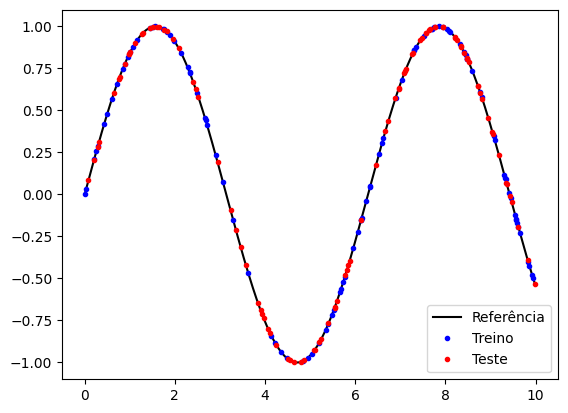

In [61]:
tc.manual_seed(21)

# Definindo intervalo e número de pontos
t_i = 0
t_f = 10
n_pontos = 200
train_test_ratio = 0.5

# Definindo constantes físicas
x_0 = 0
v_0 = 1
k = 1
m = 1

# Pontos analíticos
t = tc.linspace(t_i, t_f, n_pontos*10)

def x_analitico(t):
    return x_0 * tc.cos(tc.sqrt(tc.tensor(k/m)) * t) + v_0 * tc.sqrt(tc.tensor(m/k)) * tc.sin(tc.sqrt(tc.tensor(k/m)) * t)

x_ref = x_analitico(t)

# Pontos analíticos aleatórios
rand_indices = tc.randint(0, n_pontos*10, (n_pontos,))
novo_t = t[rand_indices]
novo_x_ref = x_ref[rand_indices]

# Treino e teste
split_index = int(n_pontos*train_test_ratio)

t_treino = novo_t[:split_index].clone().detach().reshape(-1, 1)
t_treino.requires_grad_(True)
x_treino = novo_x_ref[:split_index].clone().detach().reshape(-1, 1)

t_teste = novo_t[split_index:].clone().detach().reshape(-1, 1)
x_teste = novo_x_ref[split_index:].clone().detach().reshape(-1, 1)

# Condições iniciais
condicoes_iniciais = tc.tensor([x_0, v_0])
t_treino = tc.cat([tc.tensor([[0.0]]), t_treino])
x_treino = tc.cat([tc.tensor([[x_0]]), x_treino]) 

plt.plot(t, x_ref, 'k-', label='Referência')
plt.plot(t_treino.detach().numpy(), x_treino, 'b.', label='Treino')
plt.plot(t_teste, x_teste, 'r.', label='Teste')
plt.legend(loc="lower right")
plt.show()


#### Definindo rede neural

In [62]:
class PINN(nn.Module):

    def __init__(self, structure=[1, 10, 10, 1], activation=nn.Tanh()):
        super(PINN, self).__init__()
        self.structure = structure
        self.activation = activation
        self.hidden_layers = nn.ModuleList()

        for i in range(len(structure)-1):
            self.hidden_layers.append(nn.Linear(structure[i], structure[i+1]))
    
    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.activation(layer(x))
        x = self.hidden_layers[-1](x) # Sem ativação na última camada
        return x


#### Treino

In [63]:
tc.manual_seed(21)

OHS = PINN(structure=[1, 50, 50, 50, 1])
optimizer = tc.optim.Adam(OHS.parameters(), lr=0.00005)
scheduler = StepLR(optimizer, step_size=5000, gamma=0.9)

loss_log = []
epochs = 100000

for epoch in range(epochs):
    x_inferencia = OHS(t_treino) # inferencia dos dados de treino

    # x_dot e x_dot_dot
    dx_dt = tc.autograd.grad(x_inferencia, t_treino, grad_outputs = tc.ones_like(x_inferencia), create_graph=True)[0] 
    d2x_dt2 = tc.autograd.grad(dx_dt, t_treino, grad_outputs = tc.ones_like(dx_dt), create_graph=True)[0]

    #loss_dados = tc.mean((x_inferencia - x_treino)**2) # Supervisionado
    loss_dados = tc.tensor(0.0) # Não supervisionado
    loss_EDP = tc.mean((d2x_dt2 + tc.tensor(k/m)*x_inferencia)**2) # EDP
    loss_CI = (x_inferencia[0] - condicoes_iniciais[0])**2 + (dx_dt[0] - condicoes_iniciais[1])**2 # Condições iniciais
    loss = loss_dados + loss_EDP + loss_CI

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    tc.nn.utils.clip_grad_norm_(OHS.parameters(), max_norm=5.0) # Gradient clipping 
    optimizer.step()
    scheduler.step()

    # Salvando loss e printando a cada 1000 epochs
    loss_log.append([loss.item(), loss_dados.item(), loss_EDP.item(), loss_CI.item()])
    (lambda epoch: print(f"Epoch {epoch} - Loss: {loss.item():.2e}") if epoch % 1000 == 0 else None)(epoch)

Epoch 0 - Loss: 1.09e+00
Epoch 1000 - Loss: 5.34e-02
Epoch 2000 - Loss: 3.60e-02
Epoch 3000 - Loss: 2.78e-02
Epoch 4000 - Loss: 2.28e-02
Epoch 5000 - Loss: 1.99e-02
Epoch 6000 - Loss: 1.83e-02
Epoch 7000 - Loss: 1.59e-02
Epoch 8000 - Loss: 1.38e-02
Epoch 9000 - Loss: 1.20e-02
Epoch 10000 - Loss: 9.53e-03
Epoch 11000 - Loss: 7.68e-03
Epoch 12000 - Loss: 5.90e-03
Epoch 13000 - Loss: 3.52e-03
Epoch 14000 - Loss: 1.74e-03
Epoch 15000 - Loss: 6.05e-04
Epoch 16000 - Loss: 1.25e-04
Epoch 17000 - Loss: 5.23e-05
Epoch 18000 - Loss: 3.46e-05
Epoch 19000 - Loss: 2.39e-05
Epoch 20000 - Loss: 1.64e-05
Epoch 21000 - Loss: 1.13e-05
Epoch 22000 - Loss: 7.75e-06
Epoch 23000 - Loss: 5.46e-06
Epoch 24000 - Loss: 4.14e-06
Epoch 25000 - Loss: 3.49e-06
Epoch 26000 - Loss: 3.00e-06
Epoch 27000 - Loss: 2.71e-06
Epoch 28000 - Loss: 2.50e-06
Epoch 29000 - Loss: 2.34e-06
Epoch 30000 - Loss: 2.21e-06
Epoch 31000 - Loss: 2.11e-06
Epoch 32000 - Loss: 2.02e-06
Epoch 33000 - Loss: 1.94e-06
Epoch 34000 - Loss: 1.87e-0

#### Plot da loss

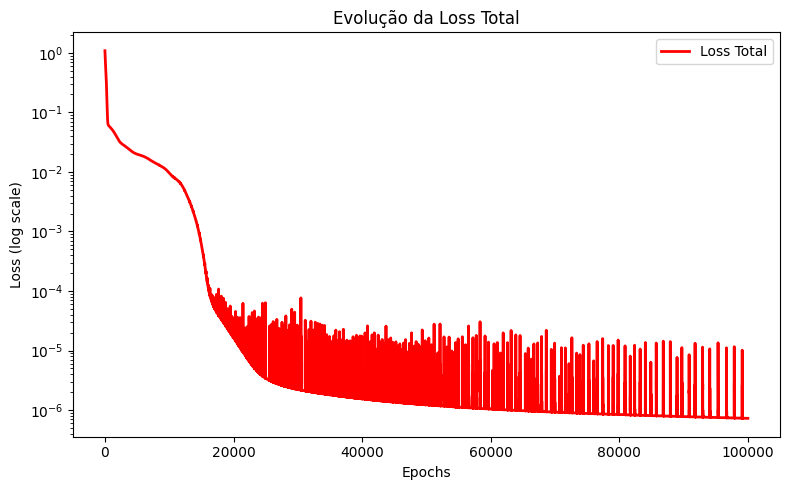

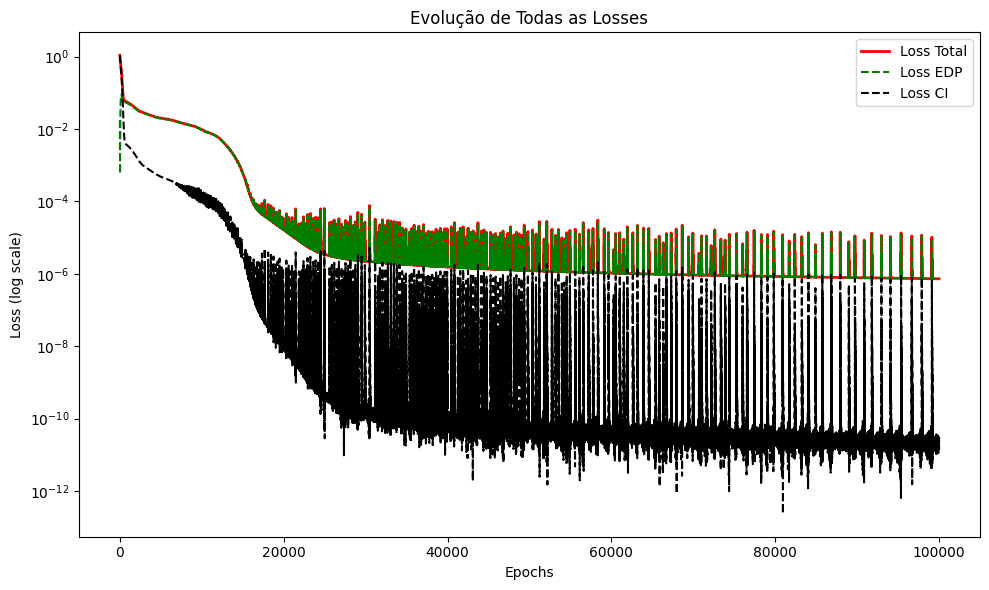

In [64]:
loss_array = np.array(loss_log)

# Figura 1: Apenas Loss Total
plt.figure(figsize=(8,5))
plt.semilogy(loss_array[:, 0], 'r-', linewidth=2, label='Loss Total')
plt.ylabel("Loss (log scale)")
plt.xlabel("Epochs")
plt.legend()
plt.title("Evolução da Loss Total")
plt.tight_layout()
plt.show()

# Figura 2: Todas as Losses
plt.figure(figsize=(10,6))
plt.semilogy(loss_array[:, 0], 'r-', linewidth=2, label='Loss Total')
#plt.semilogy(loss_array[:, 1], 'b--', linewidth=1.5, label='Loss Dados')
plt.semilogy(loss_array[:, 2], 'g--', linewidth=1.5, label='Loss EDP')
plt.semilogy(loss_array[:, 3], 'k--', linewidth=1.5, label='Loss CI')
plt.ylabel("Loss (log scale)")
plt.xlabel("Epochs")
plt.legend()
plt.title("Evolução de Todas as Losses")
plt.tight_layout()
plt.show()

#### Verificação com dados de teste

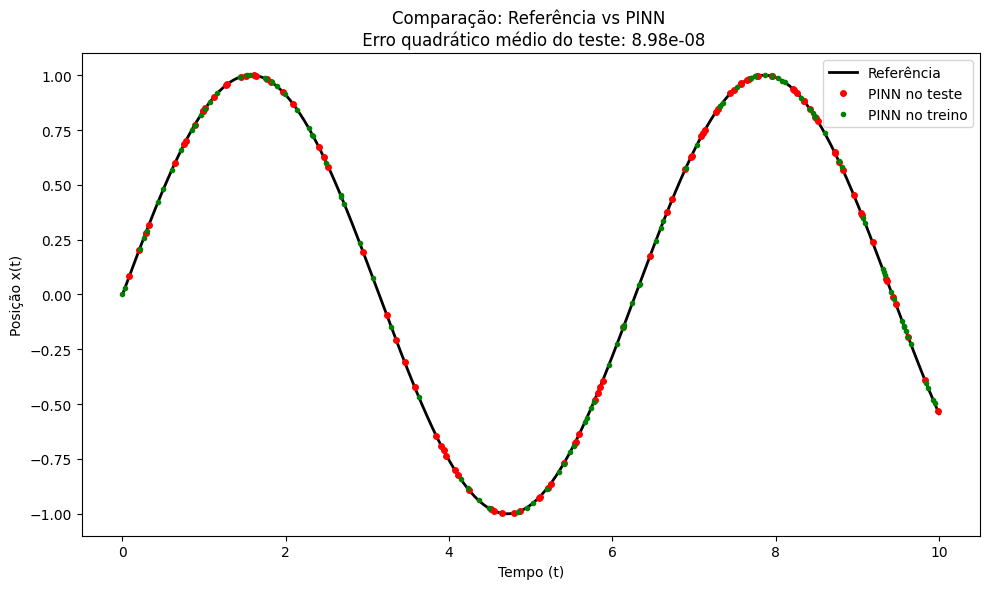

In [66]:
x_inferencia = OHS(t_teste)
x_inferencia_treino = OHS(t_treino)

erro_medio = tc.mean(tc.abs(x_inferencia - x_teste)**2).item()
erro_medio_treino = tc.mean(tc.abs(x_inferencia_treino - x_treino)**2).item()

# Plot da inferencia com dados de teste
plt.figure(figsize=(10,6))
plt.plot(t.detach().numpy(), x_ref.detach().numpy(), 'k-', label='Referência', linewidth=2)
plt.plot(t_teste.detach().numpy(), x_inferencia.detach().numpy(), 'r.', markersize=8, label='PINN no teste')
plt.plot(t_treino.detach().numpy(), x_inferencia_treino.detach().numpy(), 'g.', label='PINN no treino', linewidth=2)
plt.xlabel('Tempo (t)')
plt.ylabel('Posição x(t)')
plt.title(f'Comparação: Referência vs PINN \n Erro quadrático médio do teste: {erro_medio:.2e}')
plt.legend()
plt.tight_layout()
plt.show()

